# CS444 Assignment 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os

from kaggle_submission import output_submission_csv
from models.neural_net import NeuralNetwork
from utils.data_process import get_FASHION_data

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots

# For auto-reloading external modules
# See http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Loading Fashion-MNIST
Now that you have implemented a neural network that passes gradient checks and works on toy data, you will test your network on the Fashion-MNIST dataset.

In [3]:
# You can change these numbers for experimentation
# For submission be sure they are set to the default values
TRAIN_IMAGES = 50000
VAL_IMAGES = 10000
TEST_IMAGES = 10000

data = get_FASHION_data(TRAIN_IMAGES, VAL_IMAGES, TEST_IMAGES)
X_train, y_train = data['X_train'], data['y_train']
X_val, y_val = data['X_val'], data['y_val']
X_test, y_test = data['X_test'], data['y_test']

## Train using SGD
To train our network we will use SGD. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

You can try different numbers of layers and other hyperparameters on the Fashion-MNIST dataset below.

In [4]:
def train(num_layers, hidden_size, learning_rate, reg_const, opt = "SGD", log = False):
    global X_train, y_train, X_val, y_val
    
    epochs = 80
    input_size = 28 * 28
    num_classes = 10
    batch_size = 200
    learning_rate_decay = 0.95
    hidden_sizes = [hidden_size] * (num_layers - 1)
    
    # Initialize a new neural network model
    net = NeuralNetwork(input_size, hidden_sizes, num_classes, num_layers)

    # Variables to store performance for each epoch
    train_loss = np.zeros(epochs)
    train_accuracy = np.zeros(epochs)
    val_accuracy = np.zeros(epochs)

    # For each epoch...
    for epoch in range(epochs):    
        # Shuffle the dataset
        indices = np.random.permutation(len(X_train))
        X_train = X_train[indices]
        y_train = y_train[indices]
        
        # Training
        # For each mini-batch...
        for batch in range(TRAIN_IMAGES // batch_size):
            # Create a mini-batch of training data and labels
            X_batch = X_train[batch * batch_size: (batch + 1) * batch_size]
            y_batch = y_train[batch * batch_size: (batch + 1) * batch_size]
            
            # Run the forward pass of the model to get a prediction and compute the accuracy
            score = net.forward(X_batch)
            y_pred = np.argmax(score, axis=1)
            train_accuracy[epoch] += (y_pred == y_batch).sum()

            # Run the backward pass of the model to compute the loss, and update the weights
            loss = net.backward(y_batch, reg_const)
            train_loss[epoch] += loss

            net.update(lr=learning_rate, opt=opt)

        train_accuracy[epoch] /= TRAIN_IMAGES

        if log:
            print(f'Epoch {epoch + 1}/{epochs}: loss = {loss:.4f}, accuracy = {train_accuracy[epoch]:.4f}')

        # Validation
        # No need to run the backward pass here, just run the forward pass to compute accuracy
        score = net.forward(X_val)
        y_pred = np.argmax(score, axis=1)

        val_accuracy[epoch] += (y_pred == y_val).sum() / len(y_val)
        
        # Implement learning rate decay
        learning_rate *= learning_rate_decay
    
    return train_loss, train_accuracy, val_accuracy, net

In [5]:
def get_acc(net):
    y_test_pred = np.argmax(net.forward(X_test), axis=1)
    y_val_pred = np.argmax(net.forward(X_val), axis=1)

    test_acc = (y_test_pred == y_test).sum() / len(y_test)
    val_acc = (y_val_pred == y_val).sum() / len(y_val)

    return val_acc, test_acc

In [ ]:
train_loss, train_acc, val_acc, net = train(3, 32, 1e-3, 0.2, "SGD", True)
get_acc(net)

## Train using Adam
Next we will train the same model using the Adam optimizer. You should take the above code for SGD and modify it to use Adam instead. For implementation details, see the lecture slides. The original paper that introduced Adam is also a good reference, and contains suggestions for default values: https://arxiv.org/pdf/1412.6980.pdf

In [131]:
train_loss, train_acc, val_acc, net = train(3, 32, 0.001, 0.2, "Adam", True)
get_acc(net)

Epoch 1/100: loss = 0.4675, accuracy = 0.7738
Epoch 2/100: loss = 0.3804, accuracy = 0.8555
Epoch 3/100: loss = 0.3977, accuracy = 0.8697
Epoch 4/100: loss = 0.4118, accuracy = 0.8754
Epoch 5/100: loss = 0.3129, accuracy = 0.8803
Epoch 6/100: loss = 0.3279, accuracy = 0.8856
Epoch 7/100: loss = 0.2653, accuracy = 0.8902
Epoch 8/100: loss = 0.2629, accuracy = 0.8910
Epoch 9/100: loss = 0.2791, accuracy = 0.8952
Epoch 10/100: loss = 0.2697, accuracy = 0.8966
Epoch 11/100: loss = 0.2949, accuracy = 0.8999
Epoch 12/100: loss = 0.2392, accuracy = 0.9005
Epoch 13/100: loss = 0.2146, accuracy = 0.9021
Epoch 14/100: loss = 0.3038, accuracy = 0.9052
Epoch 15/100: loss = 0.2889, accuracy = 0.9067
Epoch 16/100: loss = 0.2260, accuracy = 0.9072
Epoch 17/100: loss = 0.2161, accuracy = 0.9106
Epoch 18/100: loss = 0.2156, accuracy = 0.9101
Epoch 19/100: loss = 0.2444, accuracy = 0.9122
Epoch 20/100: loss = 0.2375, accuracy = 0.9136
Epoch 21/100: loss = 0.1653, accuracy = 0.9136
Epoch 22/100: loss = 0

(0.8868, 0.8781)

## Graph loss and train/val accuracies

Examining the loss graph along with the train and val accuracy graphs should help you gain some intuition for the hyperparameters you should try in the hyperparameter tuning below. It should also help with debugging any issues you might have with your network.

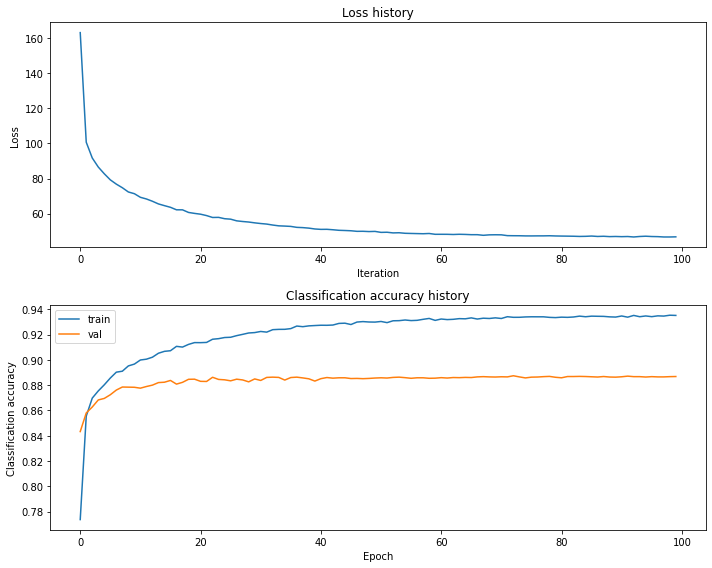

In [132]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(train_loss)
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Hyperparameter tuning

Once you have successfully trained a network you can tune your hyparameters to increase your accuracy.

Based on the graphs of the loss function above you should be able to develop some intuition about what hyperparameter adjustments may be necessary. A very noisy loss implies that the learning rate might be too high, while a linearly decreasing loss would suggest that the learning rate may be too low. A large gap between training and validation accuracy would suggest overfitting due to a large model without much regularization. No gap between training and validation accuracy would indicate low model capacity. 

You will compare networks of two and three layers using the different optimization methods you implemented. 

The different hyperparameters you can experiment with are:
- **Batch size**: We recommend you leave this at 200 initially which is the batch size we used. 
- **Number of iterations**: You can gain an intuition for how many iterations to run by checking when the validation accuracy plateaus in your train/val accuracy graph.
- **Initialization** Weight initialization is very important for neural networks. We used the initialization `W = np.random.randn(n) / sqrt(n)` where `n` is the input dimension for layer corresponding to `W`. We recommend you stick with the given initializations, but you may explore modifying these. Typical initialization practices: http://cs231n.github.io/neural-networks-2/#init
- **Learning rate**: Generally from around 1e-4 to 1e-1 is a good range to explore according to our implementation.
- **Learning rate decay**: We recommend a 0.95 decay to start.
- **Hidden layer size**: You should explore up to around 120 units per layer. For three-layer network, we fixed the two hidden layers to be the same size when obtaining the target numbers. However, you may experiment with having different size hidden layers.
- **Regularization coefficient**: We recommend trying values in the range 0 to 0.1. 

Hints:
- After getting a sense of the parameters by trying a few values yourself, you will likely want to write a few for-loops to traverse over a set of hyperparameters.
- If you find that your train loss is decreasing, but your train and val accuracy start to decrease rather than increase, your model likely started minimizing the regularization term. To prevent this you will need to decrease the regularization coefficient. 

In [7]:
reg_consts = [0.0, 0.01, 0.05, 0.1, 0.2]
hidden_sizes = [20, 32, 48, 64, 100]
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

accuracies = {}

# Train the model for each combination of hyperparameters
for num_layers in [2, 3]:
    for opt in ["SGD", "Adam"]:
        for reg_const in reg_consts:
            for hidden_size in hidden_sizes:
                for learning_rate in learning_rates:
                    file_name = f'checkpoints/{num_layers}_{opt}_{reg_const}_{hidden_size}_{learning_rate}.npy'
                    if os.path.exists(file_name):
                        input_size = 28 * 28
                        num_classes = 10
                        hidden_sizes = [hidden_size] * (num_layers - 1)
                        
                        # Initialize a new neural network model
                        net = NeuralNetwork(input_size, hidden_sizes, num_classes, num_layers)
                        net.load_checkpoint(file_name)
                    else:
                        train_loss, train_acc, val_acc, net = train(num_layers, hidden_size, learning_rate, reg_const, opt)
                        net.save_checkpoint(file_name)

                    val_acc, test_acc = get_acc(net)
                    accuracies[(num_layers, opt, reg_const, hidden_size, learning_rate)] = (val_acc, test_acc)
                    print(f'num_layers = {num_layers}, opt = {opt}, reg_const = {reg_const}, hidden_size = {hidden_size}, ' +
                        f'learning_rate = {learning_rate} | val_acc = {val_acc}, test_acc = {test_acc}')

print("Training complete...")

num_layers = 2, opt = SGD, reg_const = 0.0, hidden_size = 20, learning_rate = 1e-05 | val_acc = 0.8242, test_acc = 0.8166
num_layers = 2, opt = SGD, reg_const = 0.0, hidden_size = 20, learning_rate = 0.0001 | val_acc = 0.8688, test_acc = 0.8578
num_layers = 2, opt = SGD, reg_const = 0.0, hidden_size = 20, learning_rate = 0.001 | val_acc = 0.8765, test_acc = 0.8698
num_layers = 2, opt = SGD, reg_const = 0.0, hidden_size = 20, learning_rate = 0.01 | val_acc = 0.1023, test_acc = 0.1
num_layers = 2, opt = SGD, reg_const = 0.0, hidden_size = 20, learning_rate = 0.1 | val_acc = 0.1023, test_acc = 0.1
num_layers = 2, opt = SGD, reg_const = 0.0, hidden_size = 32, learning_rate = 1e-05 | val_acc = 0.8206, test_acc = 0.8188
num_layers = 2, opt = SGD, reg_const = 0.0, hidden_size = 32, learning_rate = 0.0001 | val_acc = 0.8719, test_acc = 0.866
num_layers = 2, opt = SGD, reg_const = 0.0, hidden_size = 32, learning_rate = 0.001 | val_acc = 0.884, test_acc = 0.8762
num_layers = 2, opt = SGD, reg_co

In [8]:
best_test_accuracies = {}

for num_layers in [2, 3]:
    for opt in ["SGD", "Adam"]:
        highest_test_acc = 0
        highest_params = None

        for reg_const in reg_consts:
            for hidden_size in hidden_sizes:
                for learning_rate in learning_rates:
                    if accuracies[(num_layers, opt, reg_const, hidden_size, learning_rate)][1] > highest_test_acc:
                        highest_test_acc = accuracies[(num_layers, opt, reg_const, hidden_size, learning_rate)][1]
                        highest_params = (num_layers, opt, reg_const, hidden_size, learning_rate)
        best_test_accuracies[(num_layers, opt)] = (highest_params, highest_test_acc)
best_test_accuracies

{(2, 'SGD'): ((2, 'SGD', 0.2, 100, 0.001), 0.8915),
 (2, 'Adam'): ((2, 'Adam', 0.2, 100, 0.001), 0.8924),
 (3, 'SGD'): ((3, 'SGD', 0.1, 100, 0.001), 0.8904),
 (3, 'Adam'): ((3, 'Adam', 0.2, 100, 0.001), 0.8918)}

In [9]:
def get_test_prediction(hyper_params):
    global X_test

    num_layers, opt, reg_const, hidden_size, learning_rate = hyper_params
    file_name = f'checkpoints/{num_layers}_{opt}_{reg_const}_{hidden_size}_{learning_rate}.npy'

    input_size = 28 * 28
    num_classes = 10
    hidden_sizes = [hidden_size] * (num_layers - 1)
    
    # Initialize a new neural network model
    net = NeuralNetwork(input_size, hidden_sizes, num_classes, num_layers)
    net.load_checkpoint(file_name)
    score = net.forward(X_test)
    y_pred = np.argmax(score, axis=1)

    return y_pred
    

## Run on the test set
When you are done experimenting, you should evaluate your final trained networks on the test set.

In [12]:
best_2layer_sgd_prediction = get_test_prediction(best_test_accuracies[(2, "SGD")][0])
best_3layer_sgd_prediction = get_test_prediction(best_test_accuracies[(3, "SGD")][0])
best_2layer_adam_prediction = get_test_prediction(best_test_accuracies[(2, "Adam")][0])
best_3layer_adam_prediction = get_test_prediction(best_test_accuracies[(3, "Adam")][0])

best_test_accuracies[(2, "SGD")][1], best_test_accuracies[(3, "SGD")][1], best_test_accuracies[(2, "Adam")][1], best_test_accuracies[(3, "Adam")][1]

(0.8915, 0.8904, 0.8924, 0.8918)

## Kaggle output

Once you are satisfied with your solution and test accuracy, output a file to submit your test set predictions to the Kaggle for Assignment 2 Neural Network. Use the following code to do so:

In [13]:
output_submission_csv('./nn_2layer_sgd_submission.csv', best_2layer_sgd_prediction)
output_submission_csv('./nn_3layer_sgd_submission.csv', best_2layer_sgd_prediction)
output_submission_csv('./nn_2layer_adam_submission.csv', best_2layer_sgd_prediction)
output_submission_csv('./nn_3layer_adam_submission.csv', best_2layer_sgd_prediction)

## Compare SGD and Adam
Create graphs to compare training loss and validation accuracy between SGD and Adam. The code is similar to the above code, but instead of comparing train and validation, we are comparing SGD and Adam.

In [ ]:
# TODO: implement me